In [1]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import os
import pickle
import xarray
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy
import datetime
from scipy.stats import binned_statistic
from ll_xy import lonlat_to_xy
import matplotlib.pyplot as plt
import kuka_tools as kt

In [4]:
dir = '../../data/rothera/netcdfs/20230831'

In [5]:
listfiles = os.listdir(dir)
listfiles

ku_files = sorted([f for f in listfiles if 'Ka-Scat' in f])
# ka_files = sorted([f for f in listfiles if 'Ka-Scat' in f])

ku_files

['kuka_stare_decon_Ka-Scat20230831-131910.nc',
 'kuka_stare_decon_Ka-Scat20230831-132410.nc',
 'kuka_stare_decon_Ka-Scat20230831-132910.nc']

Text(0, 0.5, 'y distance (m)')

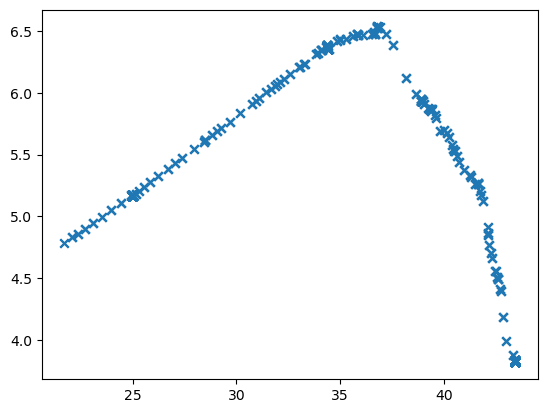

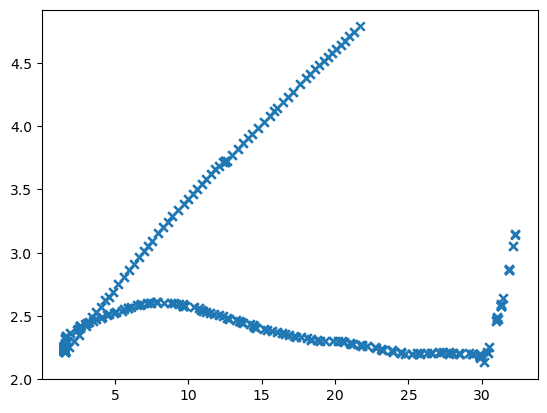

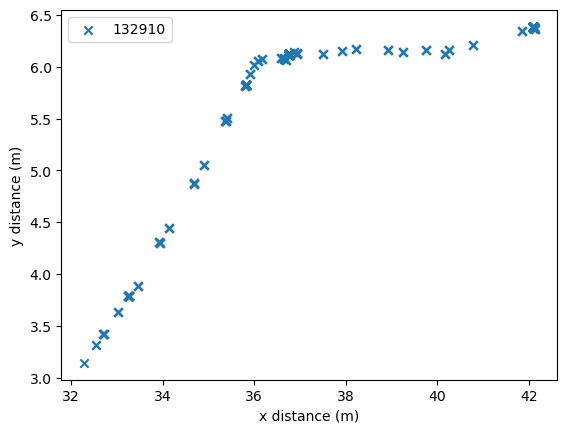

In [6]:

x,y=kt.plot_pos(ku_files[0],dir,plot=False)

x0 = -2300414.994491106; y0 = 923485.871699531

xy_dict = {}

for f in ku_files:

    x,y = kt.plot_pos(f,dir,x0=x0,y0=y0)

    xy_dict[f] = (x,y)
    
plt.legend()
plt.xlabel('x distance (m)')
plt.ylabel('y distance (m)')

# plt.xlim(-20,5)
# plt.ylim(-20,5)

In [7]:
for f in ku_files[0:2]:
    x,y = xy_dict[f]
    print(np.argmin(x),np.argmax(y))
    time_offset_s=0

1150 687
372 0


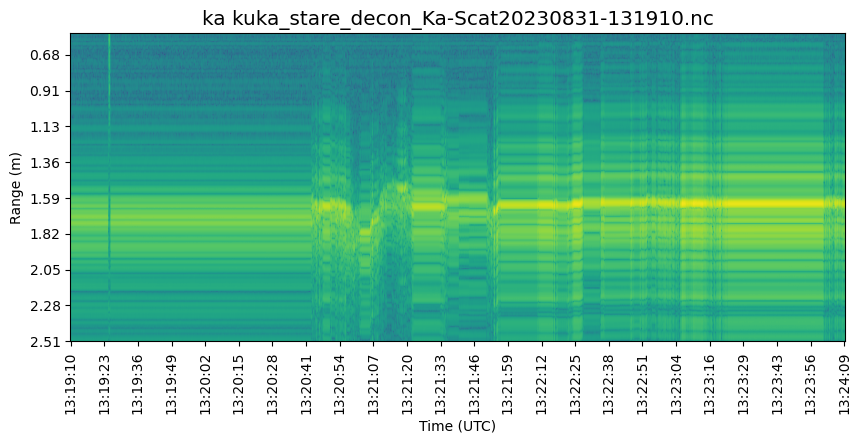

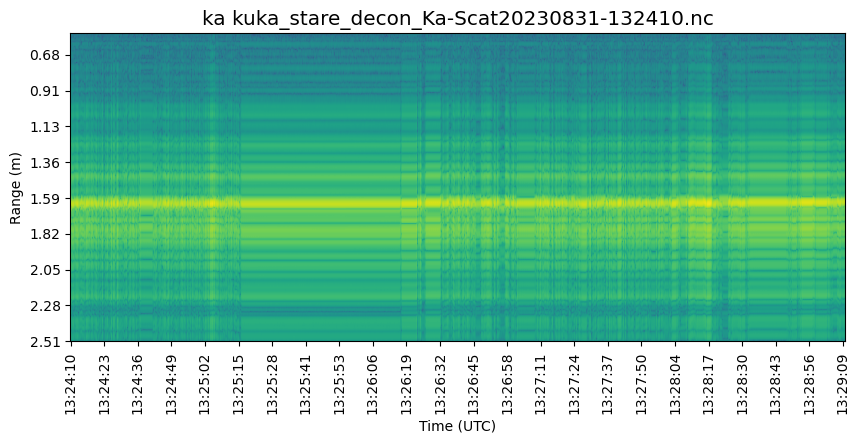

In [8]:
for f in ku_files[0:2]:
    kt.plot_file(f,'ka',dir,)
    

# Plot first file
## Start analysis at ind = 461 which is max y

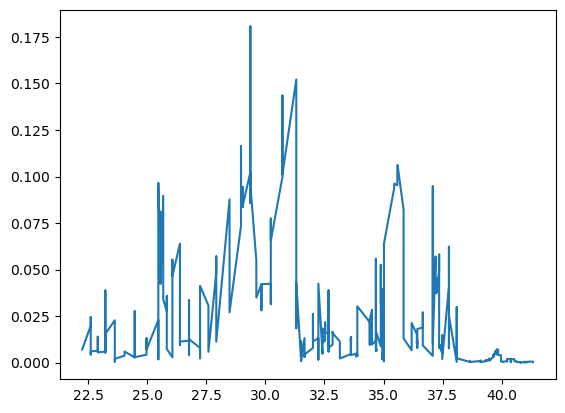

nan


/tmp/ipykernel_30698/1579254800.py:33: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(bs[0][bin_centres<20])


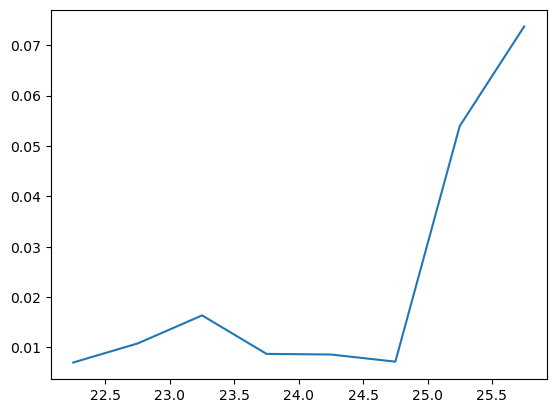

In [9]:
foi = ku_files[0]
d = Dataset(f'{dir}/{foi}')
x,y = xy_dict[foi]

range = np.array(d['range'])

times = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(x)) for x in d['start_time']])

mintime=461
maxtime=-1

x_ = 0; y_ = 0

along_track = np.sqrt((x-x_)**2 + (y-y_)**2)

minrange, maxrange = kt.get_range_index(1.3,range),kt.get_range_index(2,range)

pol = 'vv'

vv_power = np.array(d[f'{pol}_power_decon0'])
vv_power_in_range = np.sum(vv_power[minrange:maxrange],axis=0)
plt.plot(along_track[mintime:maxtime],vv_power_in_range[mintime:maxtime])
bs = binned_statistic(along_track[mintime:maxtime],vv_power_in_range[mintime:maxtime],
                      statistic='mean',bins=np.arange(0,26.1,0.5))

plt.show()


bin_centres = np.arange(0.25,26.01,0.5)

plt.plot(bin_centres,bs[0])

mean = np.nanmean(bs[0][bin_centres<20])

plt.plot([0,20],[mean,mean],color='k',ls='--')

print(mean)

plt.show()


# Now plot second file, beginning at min(x) which is index 270

In [20]:
ku_files

['kuka_stare_decon_Ka-Scat20230831-131910.nc',
 'kuka_stare_decon_Ka-Scat20230831-132410.nc',
 'kuka_stare_decon_Ka-Scat20230831-132910.nc']

In [16]:
foi = ku_files[1]
d = Dataset(f'{dir}/{foi}')
x,y = xy_dict[foi]

range = np.array(d['range'])

time_offset_s=0
times = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(x))+datetime.timedelta(seconds=int(time_offset_s)) for x in d['start_time']])

mintime = kt.get_time_index(datetime.datetime(2023,8,31,13,26,20),times)
mintime = 270
# maxtime = kt.get_time_index(datetime.datetime(2023,8,31,13,29,8),times)
maxtime=-1

x_ = 0; y_ = 0

along_track = np.sqrt((x-x_)**2 + (y-y_)**2)+1

xdiff = np.diff(x)
ydiff = np.diff(y)
speed = np.sqrt(np.square(xdiff)+np.square(ydiff))
speed=list(speed)+[0]

nrcs = pd.DataFrame(kt.get_nrcs(d,'ka'))
nrcs['along_track']=along_track
nrcs['speed']=speed


nrcs = nrcs[nrcs['corr']<0.99999]
nrcs.reset_index(inplace=True,drop=True)

nrcs_return = nrcs.iloc[mintime:maxtime]

nrcs_return = nrcs_return.sort_values('along_track').reset_index()

nrcs_return = nrcs_return[nrcs_return['along_track']<30]

nrcs_return

,index,vv,hv,vh,hh,corr,along_track,speed
0,270,3.312086,0.017868,0.002215,3.621691,0.999982,3.736726,0.000000
1,271,3.276142,0.017764,0.002295,3.572159,0.995868,3.753818,0.000000
2,272,3.080159,0.018332,0.002019,3.232418,0.999056,3.753818,0.033705
3,273,0.563988,0.009231,0.002926,0.389430,0.996369,3.786241,0.000000
4,274,1.821195,0.006244,0.016376,2.016798,0.980886,3.786241,0.000000
...,...,...,...,...,...,...,...,...
465,732,4.247545,0.023530,0.002587,4.847755,0.989340,29.530594,0.011685
466,738,5.480103,0.016271,0.009639,6.075543,0.999196,29.576992,0.000000
467,739,6.233344,0.030605,0.004158,6.695759,0.997510,29.576992,0.612686
468,736,3.777635,0.023036,0.001790,4.093984,0.991158,29.576992,0.000000


In [17]:
power_threshold = np.max(nrcs_return['vv'][nrcs_return['along_track']<25])
power_threshold_arg = np.argmax(nrcs_return['vv'][nrcs_return['along_track']<25])
power_threshold,power_threshold_arg

(14.631611623809937, 17)

In [18]:
start_ind = np.argmax(nrcs_return['vv']>power_threshold)
start_along_track = nrcs_return['along_track'][start_ind]

nrcs_reverse = nrcs_return.reindex(index=nrcs_return.index[::-1])
end_ind = np.argmax(nrcs_reverse['vv']>power_threshold)
end_along_track = nrcs_reverse['along_track'].iloc[end_ind]
start_along_track,end_along_track

(26.347183918859514, 27.685752647113066)

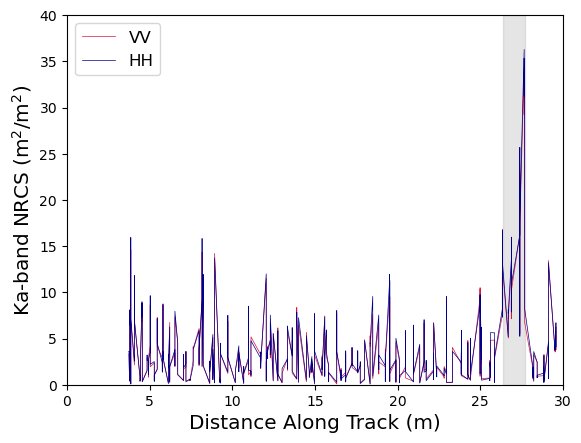

In [19]:
plt.plot(nrcs_return['along_track'],
         nrcs_return['vv'],
         label='VV',
         lw=0.5,
         color='crimson')

plt.plot(nrcs_return['along_track'],
         nrcs_return['hh'],
         label='HH',
         lw=0.5,
         color='darkblue')

plt.ylabel('Ka-band NRCS (m$^2$/m$^2$)',fontsize='x-large')
plt.xlabel('Distance Along Track (m)',fontsize='x-large')



plt.axvspan(start_along_track,end_along_track,color='grey',alpha=0.2)
plt.ylim(0,40)
plt.xlim(0,30)
plt.legend(fontsize='large')
plt.show()

In [15]:
ff_pickles = '/home/robbie/Dropbox/kuka_bare/data/pickles/FF_fig'
pickle.dump((nrcs_return,
             start_along_track,
             end_along_track),
            open(f'{ff_pickles}/ka31.p','wb'))

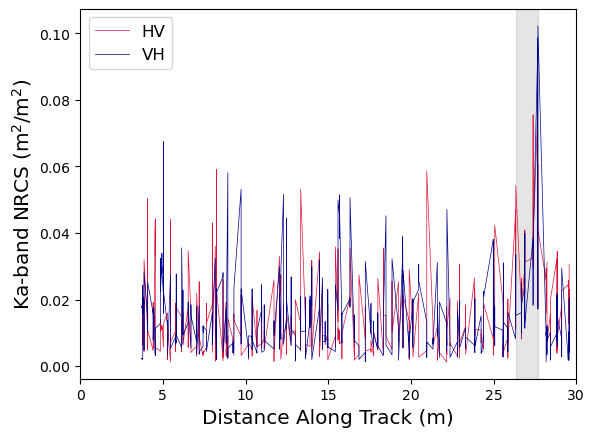

In [13]:
plt.plot(nrcs_return['along_track'],
         nrcs_return['hv'],
         label='HV',
         lw=0.5,
         color='crimson')

plt.plot(nrcs_return['along_track'],
         nrcs_return['vh'],
         label='VH',
         lw=0.5,
         color='darkblue')

plt.ylabel('Ka-band NRCS (m$^2$/m$^2$)',fontsize='x-large')
plt.xlabel('Distance Along Track (m)',fontsize='x-large')

plt.axvspan(start_along_track,end_along_track,color='grey',alpha=0.2)
# plt.ylim(0,40)
plt.xlim(0,30)
plt.legend(fontsize='large')
plt.show()

In [14]:
pickle.dump(nrcs_return,open('../../data/pickles/aug31/NRCS_KA.p','wb'))
start_along_track,end_along_track

(26.347183918859514, 27.685752647113066)